In [1]:
import os
import math
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
from skimage.morphology import skeletonize, remove_small_objects, binary_closing, label
import networkx as nx
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

In [2]:
# Constants
patch_size = 256
model_path = "artjom_234535_unet_model_256px.h5"
test_images_dir = "Kaggle (Retake)"
output_csv = "submission17.csv"

In [3]:
# Load trained segmentation model
model = load_model(model_path, custom_objects={"f1": lambda y_true, y_pred: y_true})

In [4]:
# Load and preprocess image
def load_image(image_path):
    image = Image.open(image_path)
    if image.mode in ["I;16", "I"]:
        image = (np.array(image) / 256).astype(np.uint8)
        image = np.stack([image] * 3, axis=-1)
    else:
        image = np.array(image.convert("RGB"))
    return image

In [5]:
# Remove black borders from Petri dish
def full_remove_black_borders(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    pad = 20
    return image[y+pad:y+h-pad, x+pad:x+w-pad]

In [6]:
# Clean up prediction mask
def clean_mask(mask):
    mask = remove_small_objects(mask > 0, min_size=300)
    mask = binary_closing(mask, footprint=np.ones((7, 7)))
    return (mask > 0).astype(np.uint8)

In [7]:
# Predict root mask using U-Net and post-process
def segment_roots(image, model):
    h, w, _ = image.shape
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
    dish_patches = patchify(padded, (patch_size, patch_size, 3), step=patch_size)
    predicted_patches = []
    for i in range(dish_patches.shape[0]):
        for j in range(dish_patches.shape[1]):
            patch = dish_patches[i, j, 0]
            patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            patch = patch / 255.0
            patch = np.expand_dims(patch, axis=(0, -1))
            prediction = model.predict(patch)
            predicted_patches.append(prediction[0, :, :, 0])
    predicted_patches = np.array(predicted_patches)
    predicted_patches = predicted_patches.reshape(dish_patches.shape[0], dish_patches.shape[1], patch_size, patch_size)
    predicted_mask = unpatchify(predicted_patches, padded.shape[:2])
    binary_mask = (predicted_mask > 0.3).astype(np.uint8)
    binary_mask = cv2.dilate(binary_mask, np.ones((3, 3), np.uint8), iterations=1)
    binary_mask = cv2.GaussianBlur(binary_mask.astype(np.float32), (5, 5), 0)
    return clean_mask((binary_mask > 0.3).astype(np.uint8))[:h, :w]

In [8]:
# Split mask into 5 plant regions (assumes equal spacing)
def extract_individual_roots(mask, width):
    plant_width = width // 5
    return [mask[:, i * plant_width:(i + 1) * plant_width] for i in range(5)]

In [9]:
# Extract primary root length from mask using skeleton graph traversal
def extract_primary_root(mask):
    if np.count_nonzero(mask) < 50:
        return 0, []
    skeleton = skeletonize(mask > 0)
    labeled = label(skeleton)
    best_path = []
    best_score = 0

    for i in range(1, labeled.max() + 1):
        skel_part = (labeled == i)
        coords = np.column_stack(np.nonzero(skel_part))
        if len(coords) < 10:
            continue
        G = nx.Graph()
        c_map = {tuple(c): j for j, c in enumerate(coords)}
        for j, (y, x) in enumerate(coords):
            G.add_node(j, coord=(y, x))
        for j, (y, x) in enumerate(coords):
            for dy, dx in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
                ny, nx_ = y+dy, x+dx
                if (ny, nx_) in c_map:
                    G.add_edge(j, c_map[(ny, nx_)])
        starts = sorted(G.nodes, key=lambda n: G.nodes[n]["coord"][0])[:5]
        for s in starts:
            lengths, paths = nx.single_source_dijkstra(G, s)
            for e, path in lengths.items():
                coords_path = [G.nodes[n]["coord"] for n in paths[e]]
                if len(coords_path) < 2:
                    continue
                dy = coords_path[-1][0] - coords_path[0][0]
                dx = coords_path[-1][1] - coords_path[0][1]
                vertical_ratio = abs(dy) / (abs(dx) + 1e-5)
                if vertical_ratio < 1.5:
                    continue
                if path > best_score:
                    best_score = path
                    best_path = coords_path

    if not best_path:
        return 0, []
    length = 0
    for i in range(len(best_path) - 1):
        y1, x1 = best_path[i]
        y2, x2 = best_path[i+1]
        length += math.hypot(y2 - y1, x2 - x1)
    return length, best_path

[INFO] Found 11 files


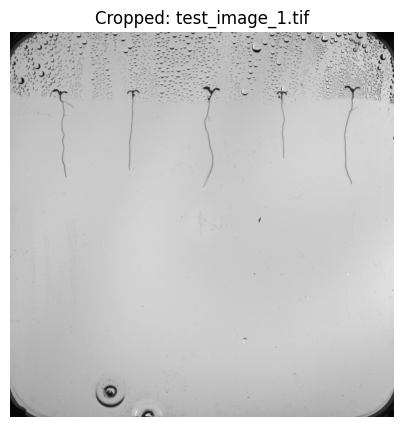

1/1 [==============================] - 0s 115ms/step


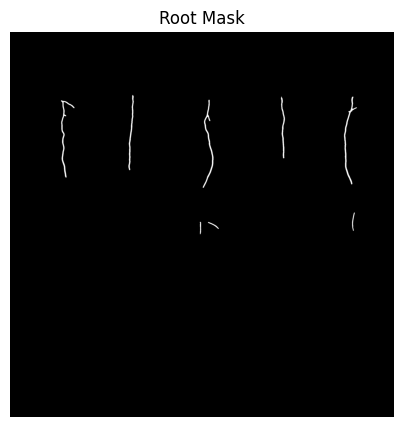

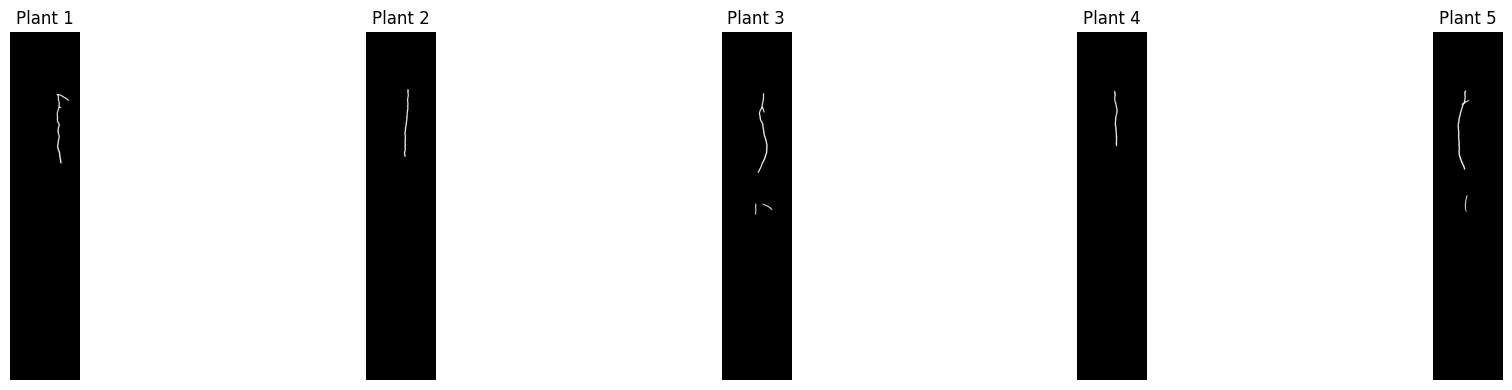

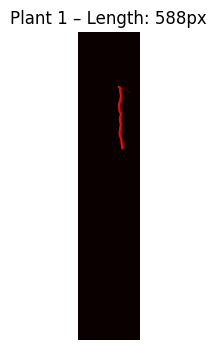

[RESULT] test_image_1.tif - Plant 1: 588px


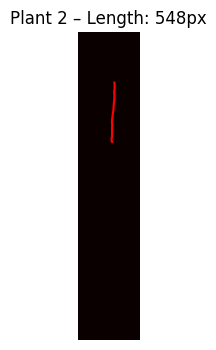

[RESULT] test_image_1.tif - Plant 2: 548px


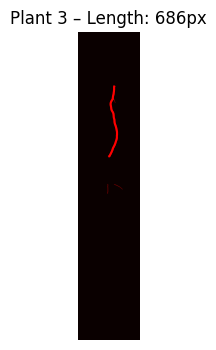

[RESULT] test_image_1.tif - Plant 3: 686px


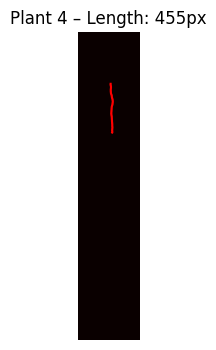

[RESULT] test_image_1.tif - Plant 4: 455px


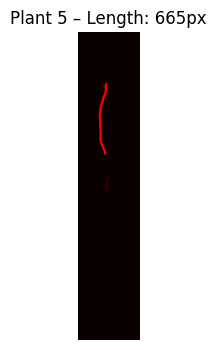

[RESULT] test_image_1.tif - Plant 5: 665px


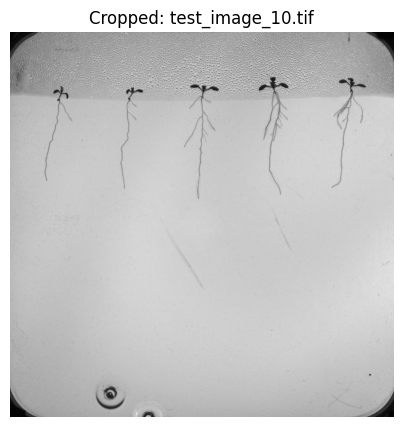

1/1 [==============================] - 0s 130ms/step


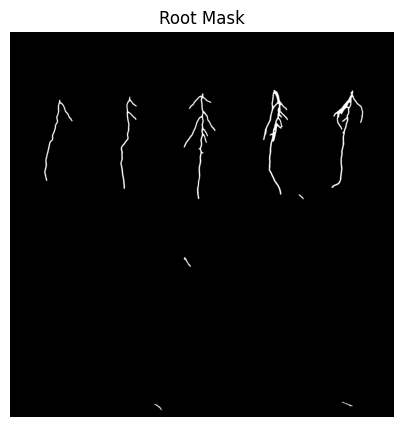

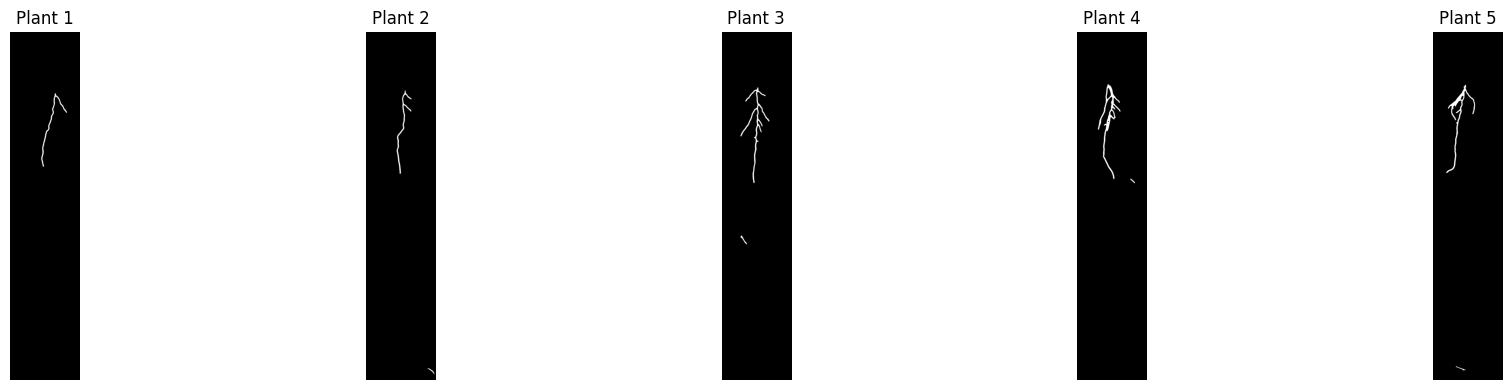

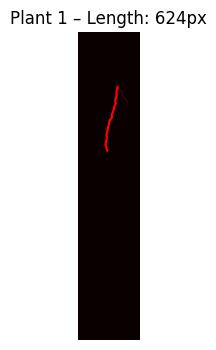

[RESULT] test_image_10.tif - Plant 1: 624px


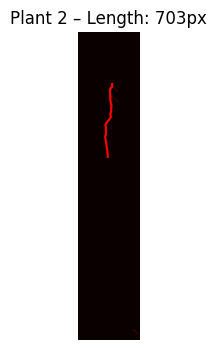

[RESULT] test_image_10.tif - Plant 2: 703px


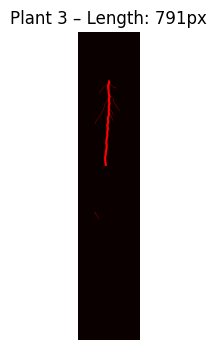

[RESULT] test_image_10.tif - Plant 3: 791px


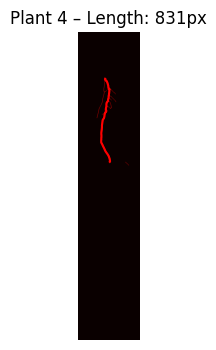

[RESULT] test_image_10.tif - Plant 4: 831px


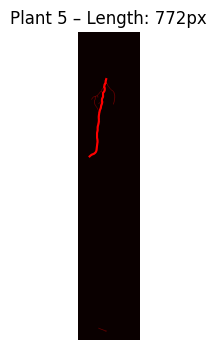

[RESULT] test_image_10.tif - Plant 5: 772px


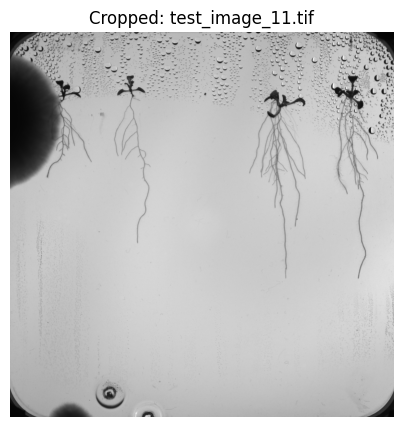

1/1 [==============================] - 0s 166ms/step


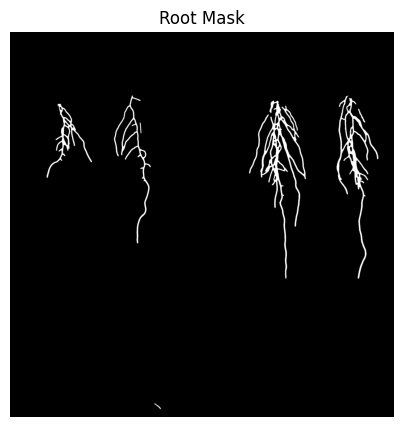

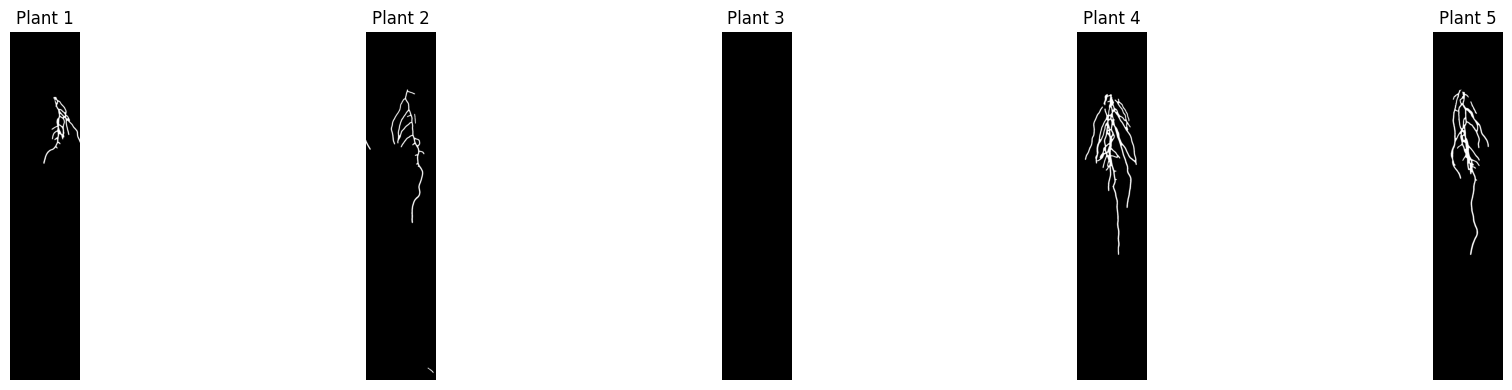

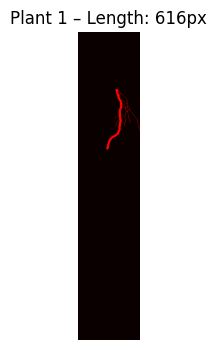

[RESULT] test_image_11.tif - Plant 1: 616px


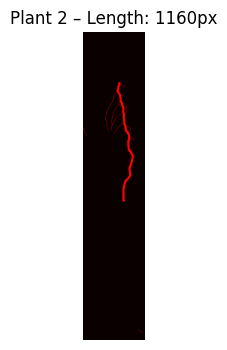

[RESULT] test_image_11.tif - Plant 2: 1160px


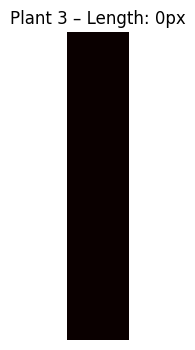

[RESULT] test_image_11.tif - Plant 3: 0px


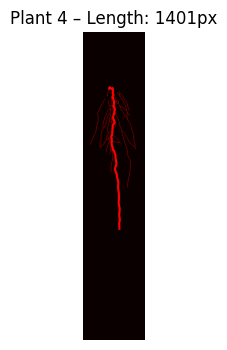

[RESULT] test_image_11.tif - Plant 4: 1401px


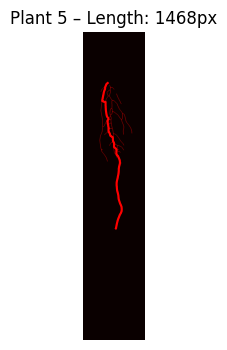

[RESULT] test_image_11.tif - Plant 5: 1468px


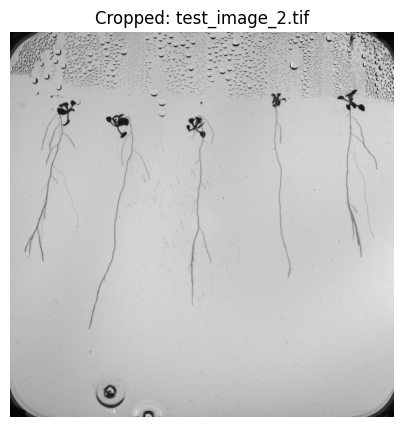

1/1 [==============================] - 0s 143ms/step


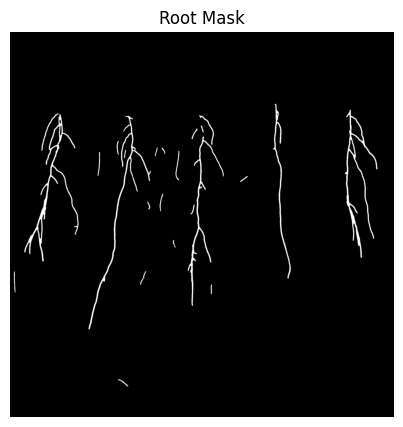

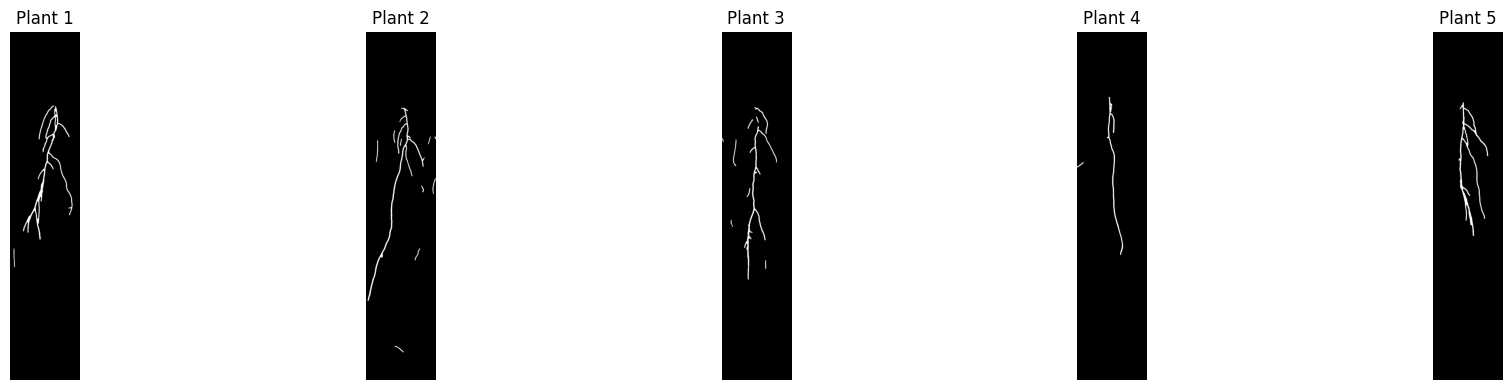

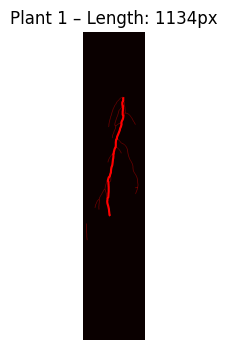

[RESULT] test_image_2.tif - Plant 1: 1134px


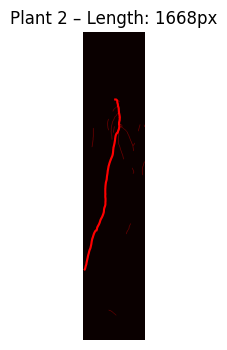

[RESULT] test_image_2.tif - Plant 2: 1668px


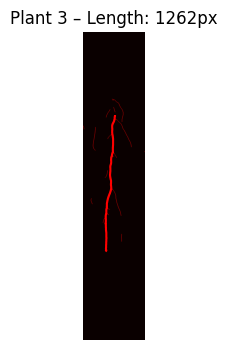

[RESULT] test_image_2.tif - Plant 3: 1262px


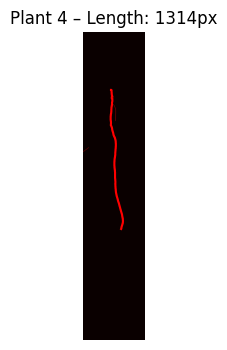

[RESULT] test_image_2.tif - Plant 4: 1314px


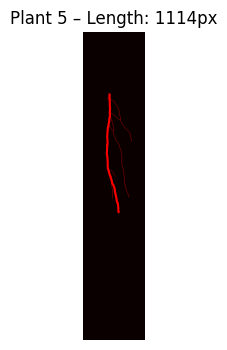

[RESULT] test_image_2.tif - Plant 5: 1114px


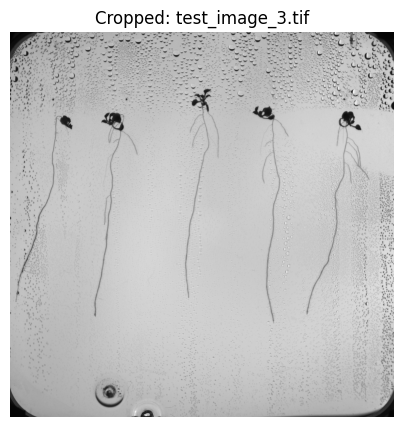

1/1 [==============================] - 0s 161ms/step


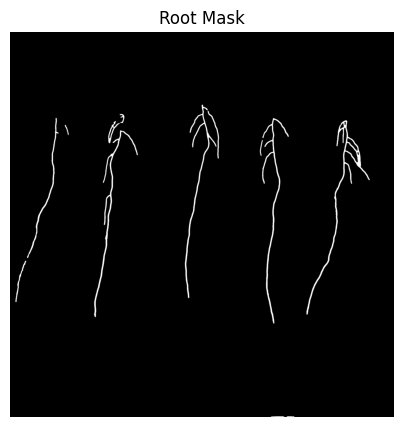

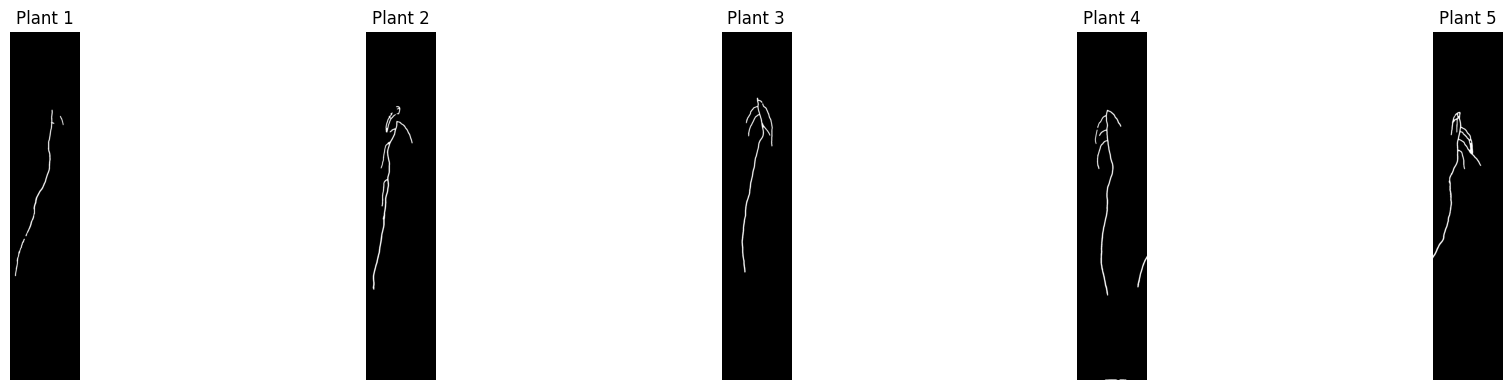

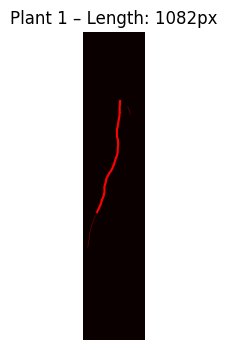

[RESULT] test_image_3.tif - Plant 1: 1082px


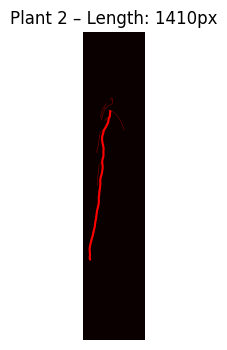

[RESULT] test_image_3.tif - Plant 2: 1410px


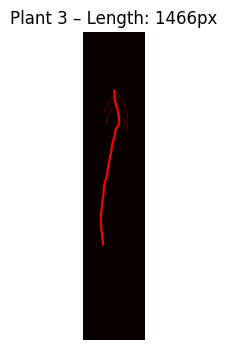

[RESULT] test_image_3.tif - Plant 3: 1466px


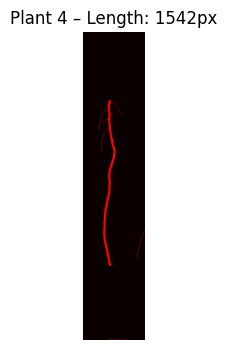

[RESULT] test_image_3.tif - Plant 4: 1542px


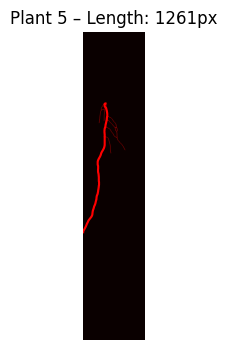

[RESULT] test_image_3.tif - Plant 5: 1261px


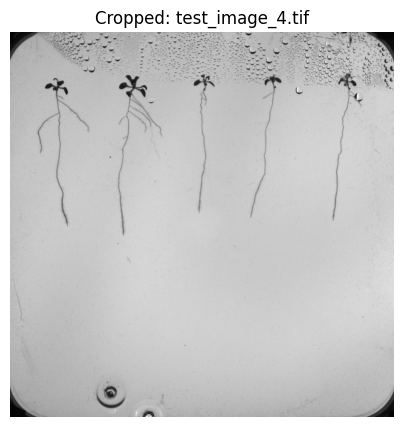

1/1 [==============================] - 0s 126ms/step


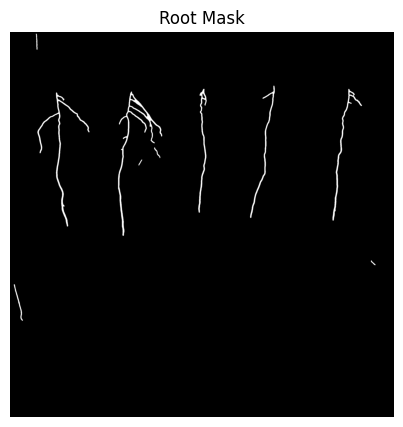

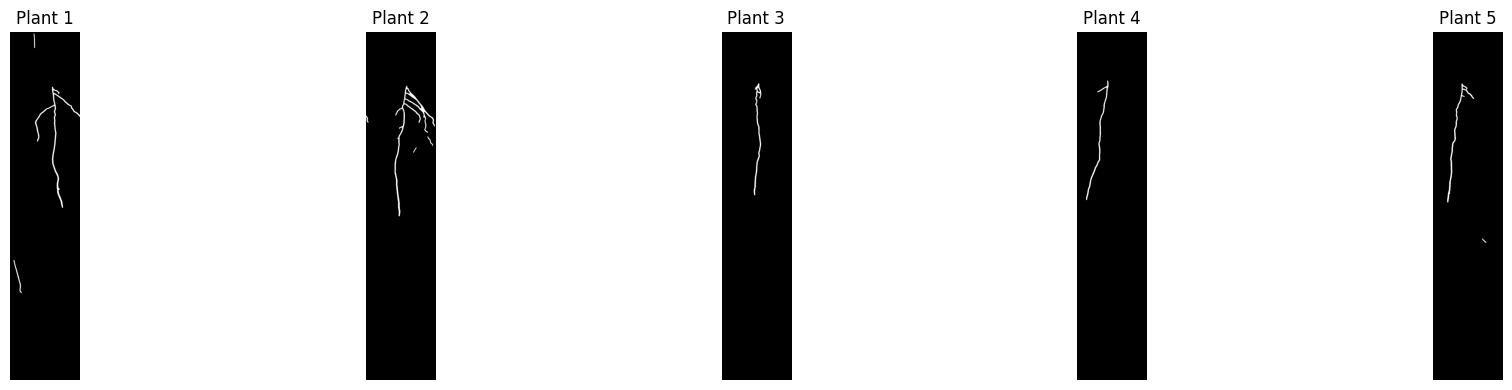

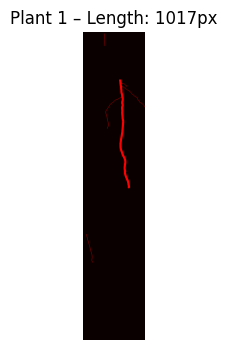

[RESULT] test_image_4.tif - Plant 1: 1017px


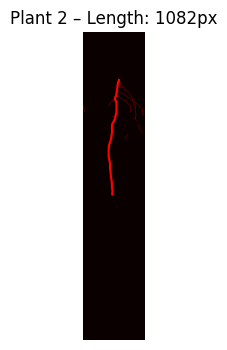

[RESULT] test_image_4.tif - Plant 2: 1082px


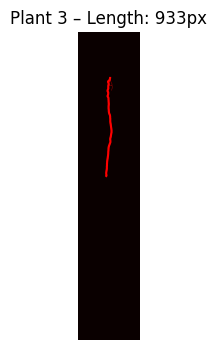

[RESULT] test_image_4.tif - Plant 3: 933px


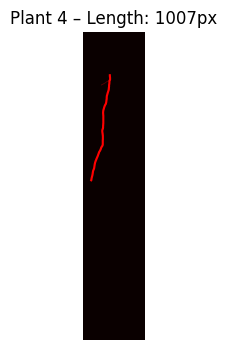

[RESULT] test_image_4.tif - Plant 4: 1007px


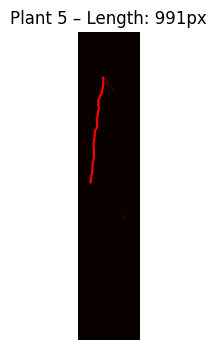

[RESULT] test_image_4.tif - Plant 5: 991px


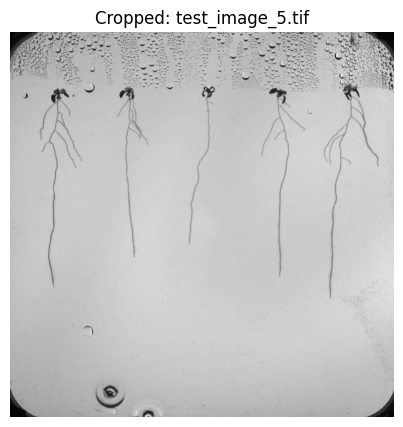

1/1 [==============================] - 0s 132ms/step


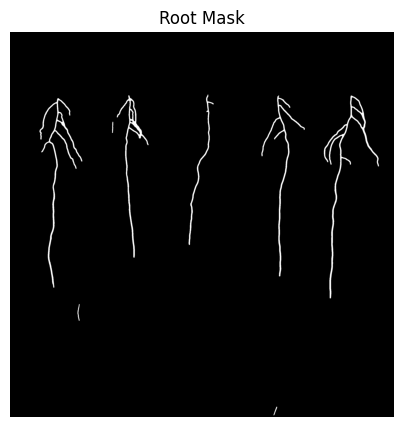

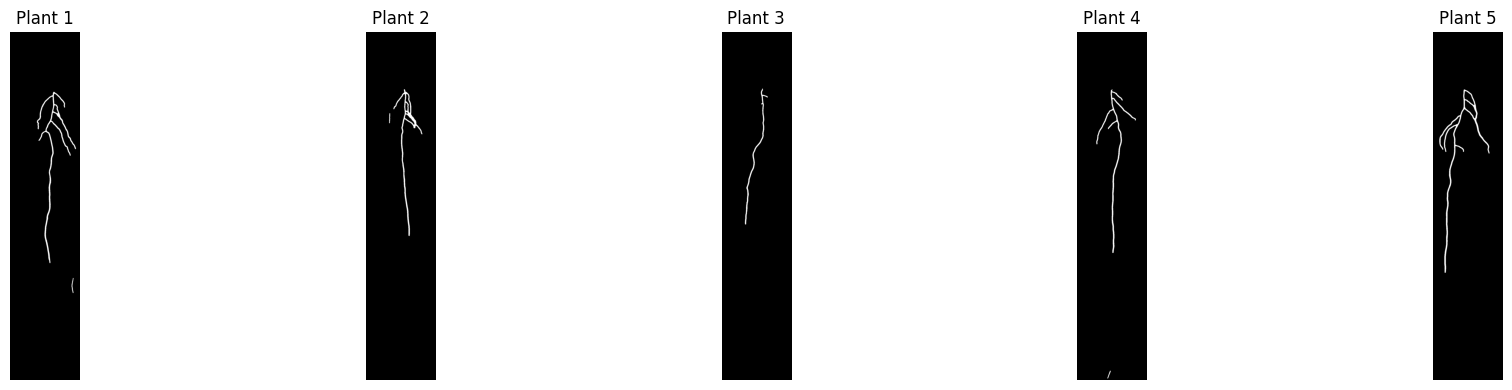

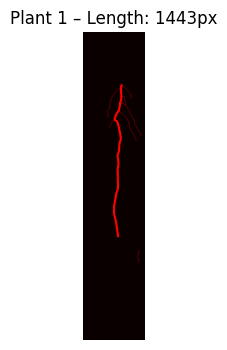

[RESULT] test_image_5.tif - Plant 1: 1443px


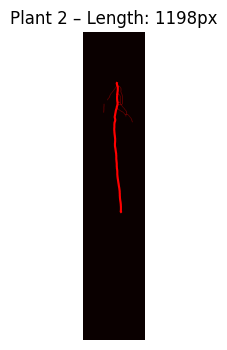

[RESULT] test_image_5.tif - Plant 2: 1198px


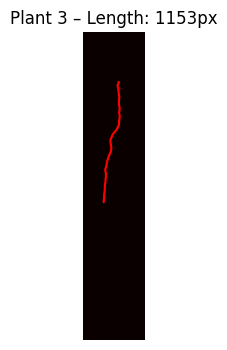

[RESULT] test_image_5.tif - Plant 3: 1153px


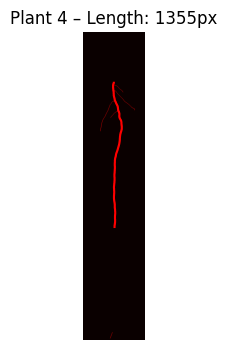

[RESULT] test_image_5.tif - Plant 4: 1355px


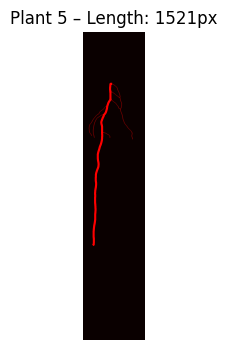

[RESULT] test_image_5.tif - Plant 5: 1521px


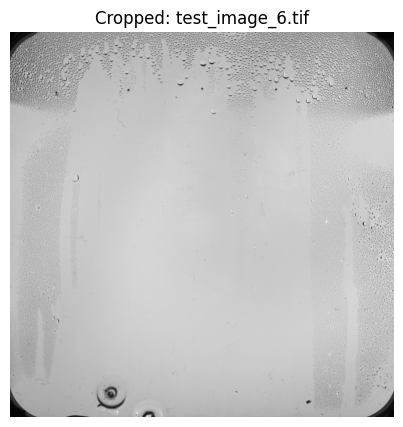

1/1 [==============================] - 0s 135ms/step


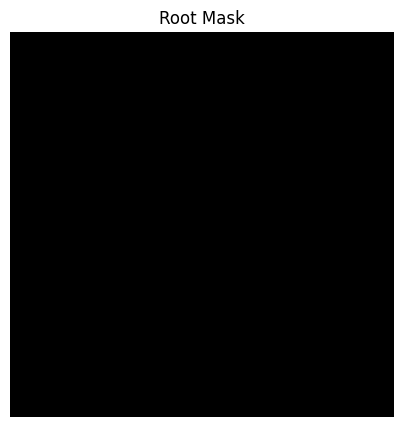

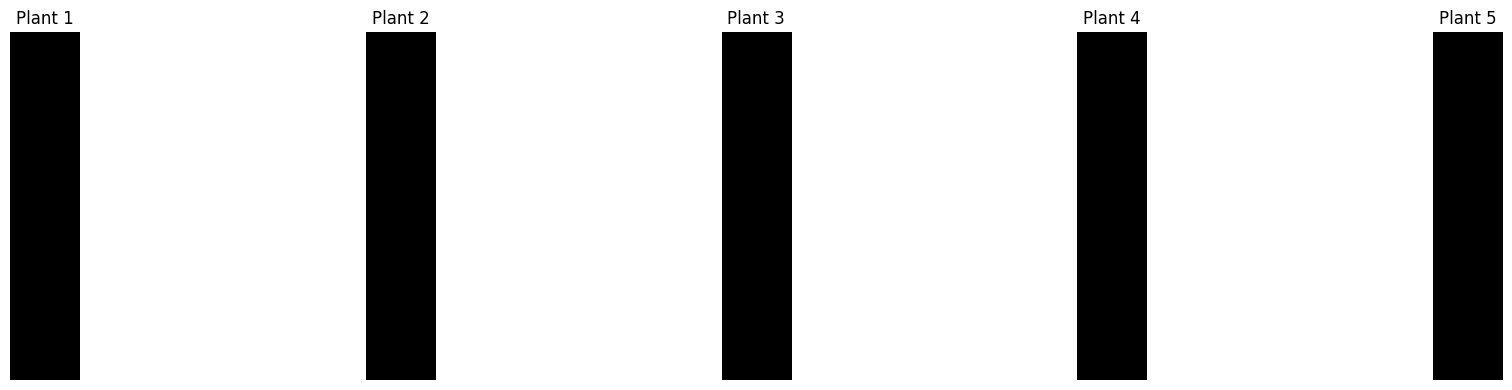

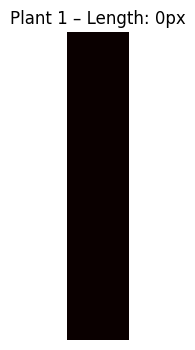

[RESULT] test_image_6.tif - Plant 1: 0px


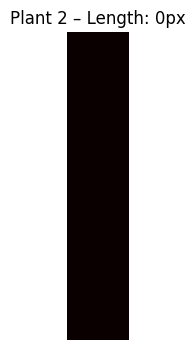

[RESULT] test_image_6.tif - Plant 2: 0px


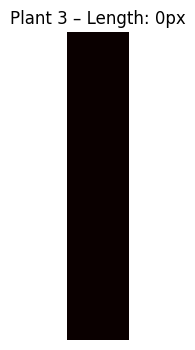

[RESULT] test_image_6.tif - Plant 3: 0px


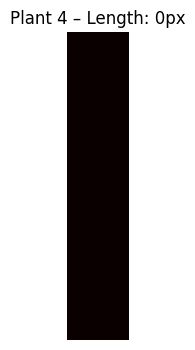

[RESULT] test_image_6.tif - Plant 4: 0px


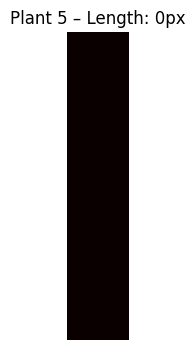

[RESULT] test_image_6.tif - Plant 5: 0px


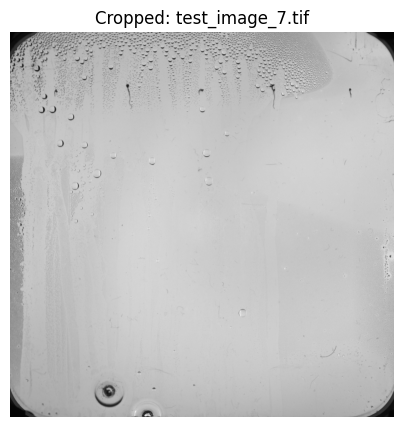

1/1 [==============================] - 0s 175ms/step


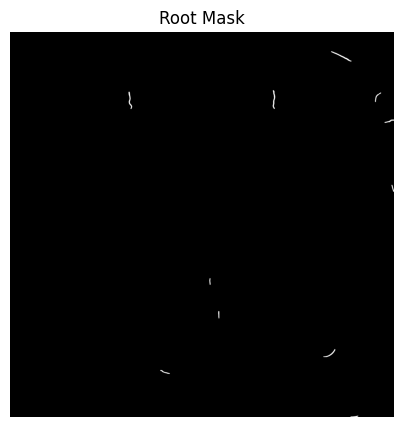

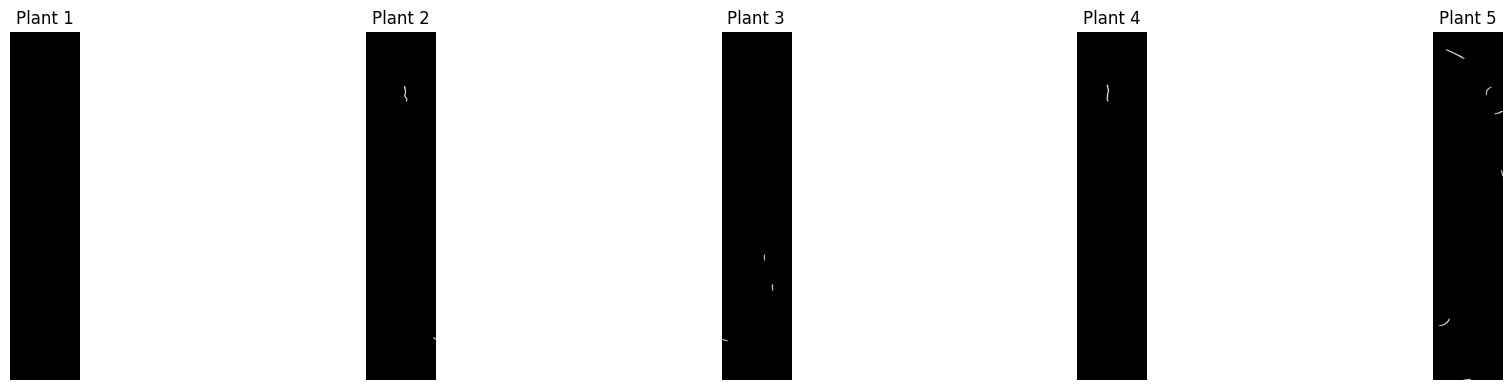

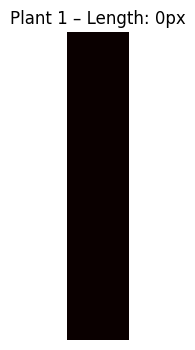

[RESULT] test_image_7.tif - Plant 1: 0px


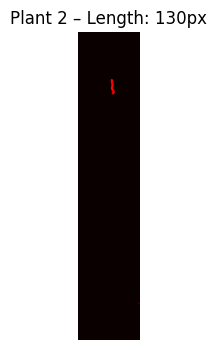

[RESULT] test_image_7.tif - Plant 2: 130px


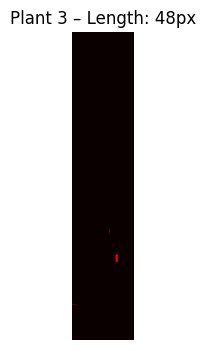

[RESULT] test_image_7.tif - Plant 3: 48px


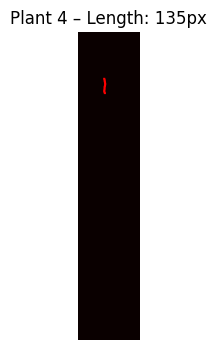

[RESULT] test_image_7.tif - Plant 4: 135px


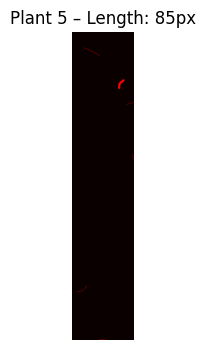

[RESULT] test_image_7.tif - Plant 5: 85px


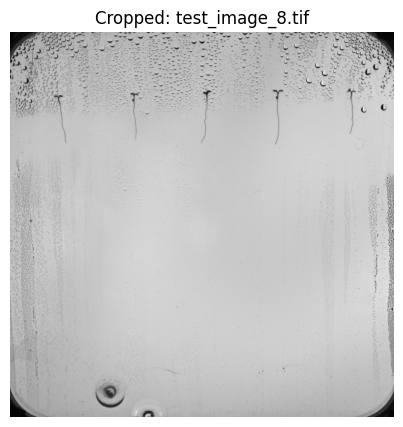

1/1 [==============================] - 0s 141ms/step


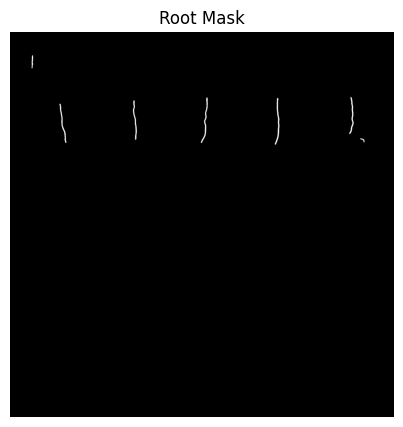

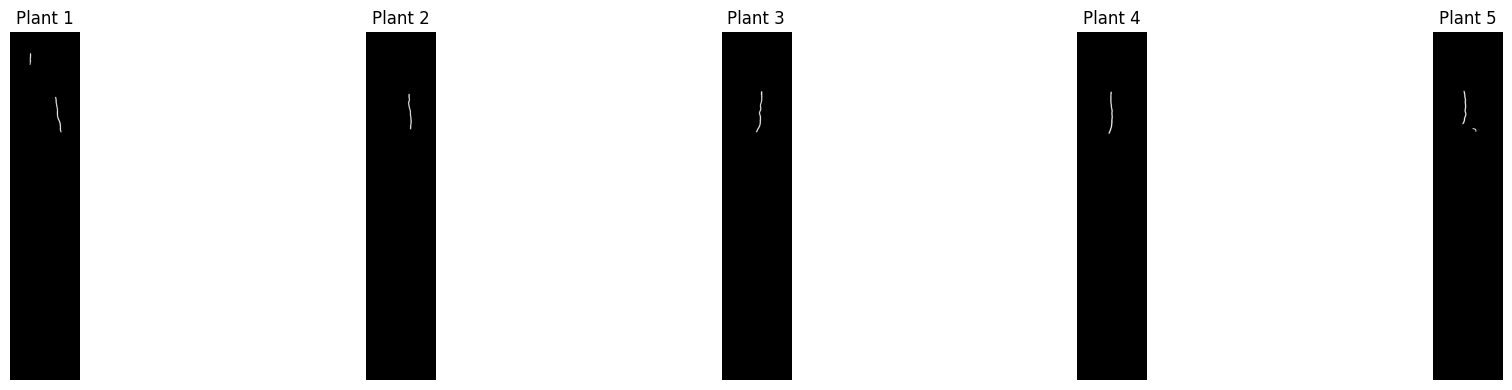

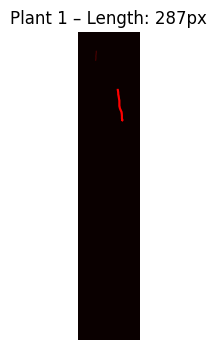

[RESULT] test_image_8.tif - Plant 1: 287px


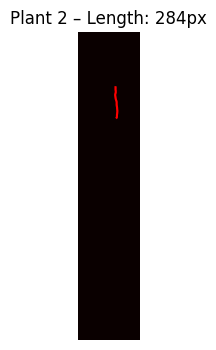

[RESULT] test_image_8.tif - Plant 2: 284px


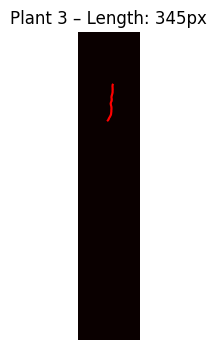

[RESULT] test_image_8.tif - Plant 3: 345px


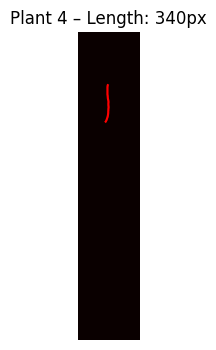

[RESULT] test_image_8.tif - Plant 4: 340px


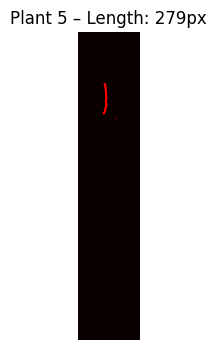

[RESULT] test_image_8.tif - Plant 5: 279px


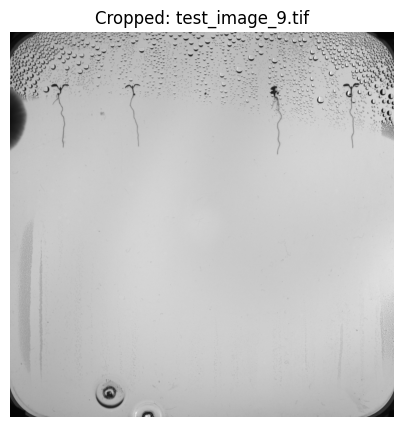

1/1 [==============================] - 0s 116ms/step


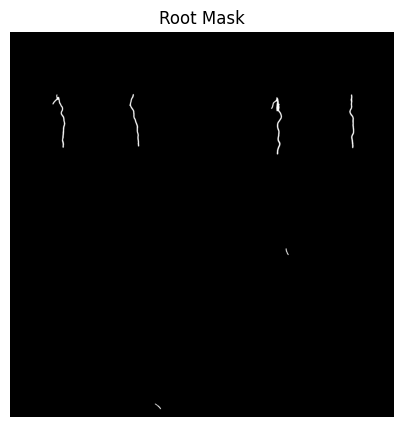

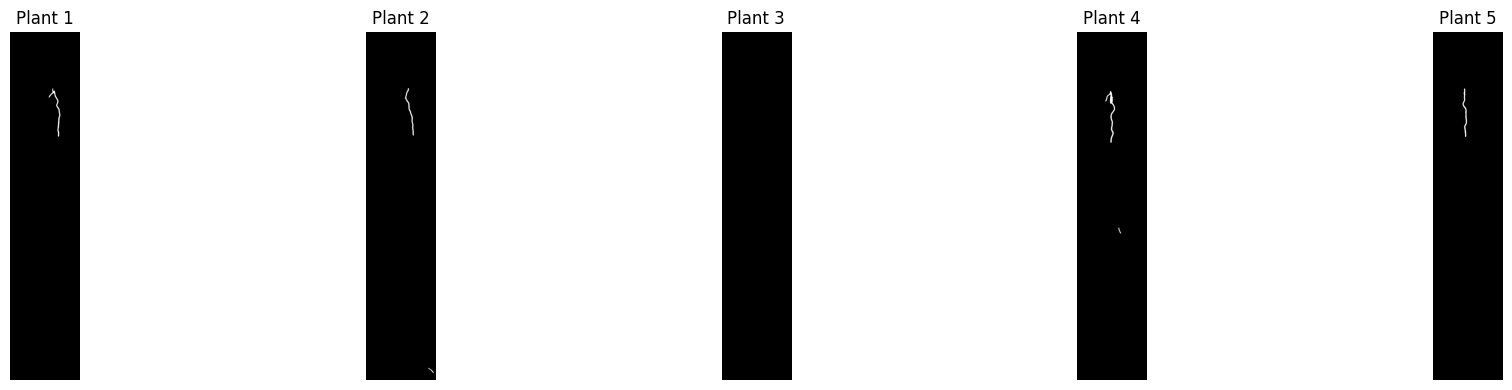

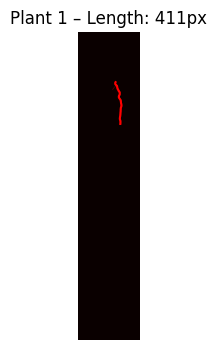

[RESULT] test_image_9.tif - Plant 1: 411px


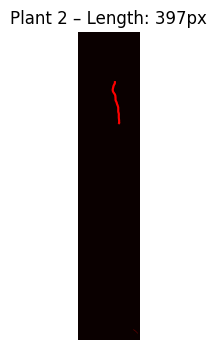

[RESULT] test_image_9.tif - Plant 2: 397px


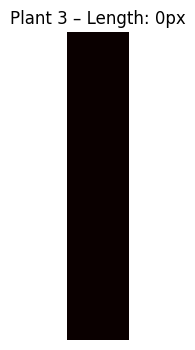

[RESULT] test_image_9.tif - Plant 3: 0px


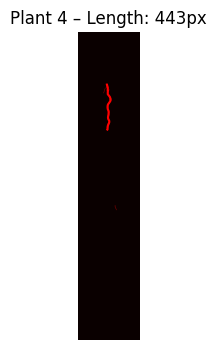

[RESULT] test_image_9.tif - Plant 4: 443px


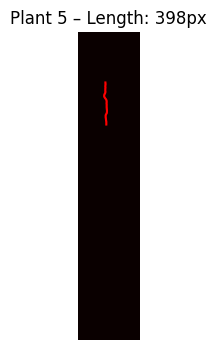

[RESULT] test_image_9.tif - Plant 5: 398px


In [10]:
# Main execution loop
predictions = []
all_files = os.listdir(test_images_dir)
print(f"[INFO] Found {len(all_files)} files")

for image_name in sorted(all_files):
    if not image_name.lower().endswith(".tif"):
        continue
    image_path = os.path.join(test_images_dir, image_name)
    image = load_image(image_path)
    if image is None or image.size == 0:
        continue
    try:
        cropped = full_remove_black_borders(image)
    except:
        continue

    plt.figure(figsize=(5, 5))
    plt.title(f"Cropped: {image_name}")
    plt.imshow(cropped)
    plt.axis("off")
    plt.show()

    root_mask = segment_roots(cropped, model)
    plt.figure(figsize=(5, 5))
    plt.title("Root Mask")
    plt.imshow(root_mask, cmap="gray")
    plt.axis("off")
    plt.show()

    individual_roots = extract_individual_roots(root_mask, cropped.shape[1])
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, root in enumerate(individual_roots):
        axs[i].imshow(root, cmap="gray")
        axs[i].set_title(f"Plant {i+1}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

    for idx, root in enumerate(individual_roots, start=1):
        skeleton = skeletonize(root > 0)
        length, path = extract_primary_root(root)
        plt.figure(figsize=(4, 4))
        plt.imshow(skeleton, cmap="hot")
        if path:
            px = [p[1] for p in path]
            py = [p[0] for p in path]
            plt.plot(px, py, c='red')
        plt.title(f"Plant {idx} – Length: {int(length)}px")
        plt.axis("off")
        plt.show()

        predictions.append({
            "Plant ID": f"{image_name.split('.')[0]}_plant_{idx}",
            "Length (px)": int(length)
        })
        print(f"[RESULT] {image_name} - Plant {idx}: {int(length)}px")

In [11]:
# Save results to CSV
pd.DataFrame(predictions).to_csv(output_csv, index=False)
print(f"\n[SAVED] CSV saved to: {output_csv}")


[SAVED] CSV saved to: submission17.csv
